In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samridhimangla","key":"57c5bd0e26fc93d00684402247314110"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c digit-recognizer

 59% 9.00M/15.3M [00:00<00:00, 93.9MB/s]
100% 15.3M/15.3M [00:00<00:00, 131MB/s] 


In [6]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import os
import random
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


In [8]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

In [9]:
train.shape

(42000, 785)

In [10]:
print(train['label'].min())
print(train['label'].max())

0
9


In [11]:
print(test.columns)

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)


In [31]:
def createImageData(raw):
  y=raw['label'].values
  x=raw[[i for i in raw.columns if i!='label']].values
  x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.1)
  return (x_train,y_train),(x_val,y_val)



In [32]:
def one_hot_encoding(labels):
  var=np.zeros((10,1))
  var[labels]=1
  return var



In [33]:
(x_train,y_train),(x_val,y_val)=createImageData(train)
#training data
train_data= [np.reshape(x,(784,1)) for x in x_train]
train_data=np.array(train_data,dtype=np.float64)
#normalize
min_val=np.min(train_data)
max_val=np.max(train_data)
train_data=(train_data-min_val)/(max_val-min_val)
train_data=np.round(train_data,5)
y_train.resize(y_train.shape[0],1)
y_train = y_train.astype(int).reshape(-1)
train_label=[one_hot_encoding(y_train[j]) for j in range(len(y_train))]
training_data=list(zip(train_data,train_label))
#validation data
train_val=[np.reshape(x,(784,1)) for x in x_val]
#normalizing validation data
train_val=np.array(train_val,dtype=np.float64)
min_val=np.min(train_val)
max_val=np.max(train_val)
train_val=(train_val-min_val)/(max_val-min_val)
train_val=np.round(train_val,5)
y_val.resize(y_val.shape[0],1)
y_val = y_val.astype(int).reshape(-1)
validation_data=list(zip(train_val,y_val))




In [16]:
train_val[0].shape

(784, 1)

In [34]:
# Have defined the Cross Entropy Cost function
class CrossEntropyCost():

  def fn(a,y):
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

  def delta(z,a,y):
    return (a-y)



In [40]:
# Defining the Neural Network
class Network():

  def __init__(self,sizes,cost=CrossEntropyCost):
    self.num_layers=len(sizes)
    self.sizes=sizes
    self.weight_initializer()
    self.cost=cost

  def weight_initializer(self):
    self.biases=[np.random.randn(y,1) for y in self.sizes[1:]]
    self.weights=[np.random.randn(y,x)/np.sqrt(x) for x, y in zip(self.sizes[:-1],self.sizes[1:])]

  def feedforward(self,a):
    for b,w in zip(self.biases,self.weights):
      a=sigmoid(np.dot(w,a)+b)
    return a

  def SGD(self,training_data,epochs,mini_batch_size,eta,lmbda,evaluation_data=None, monitor_evaluation_cost=False, monitor_evaluation_accuracy=False, monitor_training_cost=False, monitor_training_accuracy=False):

    n=len(training_data)
    if evaluation_data:
      n_data=len(evaluation_data)
    evaluation_cost, evaluation_accuracy=[],[]
    training_cost, training_accuracy=[],[]
    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches=[training_data[k:k+mini_batch_size] for k in range(0,n,mini_batch_size)]
      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch,eta,lmbda,len(training_data))
      cost = self.total_cost(training_data, lmbda)
      training_cost.append(cost)
      print(f"Cost on training data: {cost}")

      accuracy = self.accuracy(training_data, convert=True)
      training_accuracy.append(accuracy/n)
      print(f"Accuracy on training data: {accuracy} / {n}")

      cost = self.total_cost(evaluation_data, lmbda, convert=True)
      evaluation_cost.append(cost)
      print (f"Cost on evaluation data: {cost}")

      accuracy = self.accuracy(evaluation_data)
      evaluation_accuracy.append(accuracy/n_data)
      print (f"Accuracy on evaluation data: {self.accuracy(evaluation_data)} / { n_data}")
    return evaluation_cost, evaluation_accuracy,training_cost, training_accuracy

  def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

  def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)


  def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)


  def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))





Cost on training data: 0.761575858724371
Accuracy on training data: 34063 / 37800
Cost on evaluation data: 0.7913863894900793
Accuracy on evaluation data: 3747 / 4200
Cost on training data: 0.5746808204324656
Accuracy on training data: 34746 / 37800
Cost on evaluation data: 0.6180224325650708
Accuracy on evaluation data: 3822 / 4200
Cost on training data: 0.49942818438368897
Accuracy on training data: 35123 / 37800
Cost on evaluation data: 0.5528321175675
Accuracy on evaluation data: 3854 / 4200
Cost on training data: 0.4567433109221721
Accuracy on training data: 35321 / 37800
Cost on evaluation data: 0.5168851797358528
Accuracy on evaluation data: 3874 / 4200
Cost on training data: 0.421287569944617
Accuracy on training data: 35494 / 37800
Cost on evaluation data: 0.49213603748719337
Accuracy on evaluation data: 3902 / 4200
Cost on training data: 0.3968228454909095
Accuracy on training data: 35648 / 37800
Cost on evaluation data: 0.4688209128510762
Accuracy on evaluation data: 3917 / 

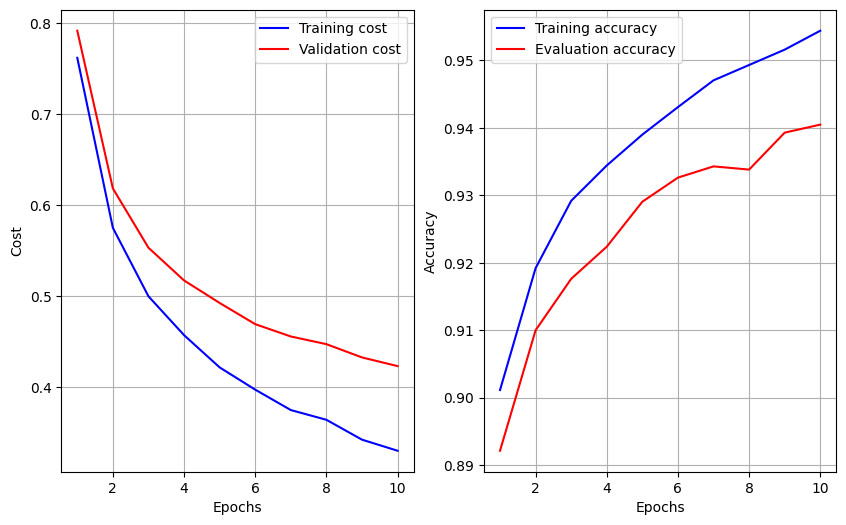

In [42]:
net=Network([784,30,10],cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy=net.SGD(training_data, 10, 64, 0.25, lmbda =0.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

epoch=10
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(range(1,epoch+1),training_cost,label="Training cost",color="blue")
plt.plot(range(1,epoch+1),evaluation_cost,label="Validation cost",color="red")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,epoch+1),training_accuracy,label="Training accuracy",color="blue")
plt.plot(range(1,epoch+1),evaluation_accuracy,label="Evaluation accuracy",color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()


Cost on training data: 1.1054243291707464
Accuracy on training data: 30766 / 37800
Cost on evaluation data: 1.136302998850979
Accuracy on evaluation data: 3394 / 4200
Cost on training data: 0.7145171286339278
Accuracy on training data: 33824 / 37800
Cost on evaluation data: 0.7557762480571316
Accuracy on evaluation data: 3736 / 4200
Cost on training data: 0.5624027341502758
Accuracy on training data: 34606 / 37800
Cost on evaluation data: 0.6003973827791294
Accuracy on evaluation data: 3813 / 4200
Cost on training data: 0.5397695856960587
Accuracy on training data: 34658 / 37800
Cost on evaluation data: 0.6018822255774509
Accuracy on evaluation data: 3799 / 4200
Cost on training data: 0.46100710822682184
Accuracy on training data: 35084 / 37800
Cost on evaluation data: 0.5111572357943339
Accuracy on evaluation data: 3873 / 4200
Cost on training data: 0.4231028546910792
Accuracy on training data: 35274 / 37800
Cost on evaluation data: 0.47048285113174537
Accuracy on evaluation data: 390

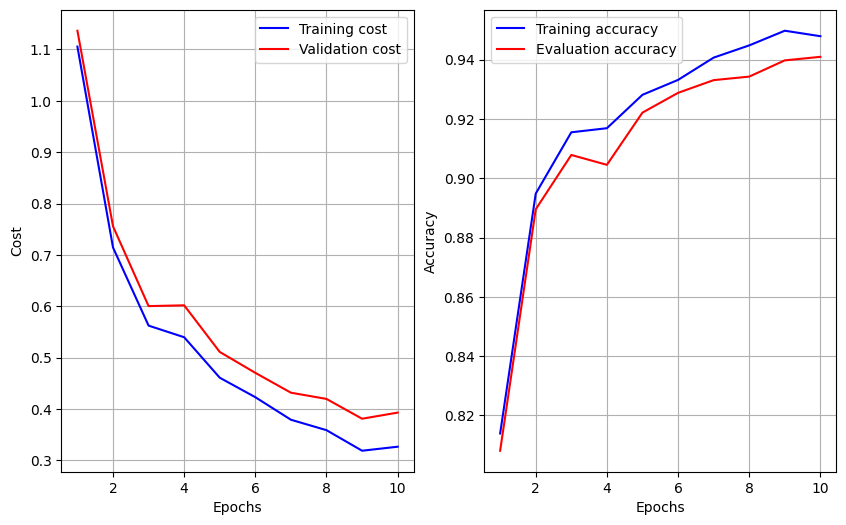

In [44]:
net=Network([784,512,512,10],cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy=net.SGD(training_data, 10, 64, 0.25, lmbda = 0.0,evaluation_data=validation_data,monitor_evaluation_accuracy=True,monitor_evaluation_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)

epoch=10
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(range(1,epoch+1),training_cost,label="Training cost",color="blue")
plt.plot(range(1,epoch+1),evaluation_cost,label="Validation cost",color="red")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,epoch+1),training_accuracy,label="Training accuracy",color="blue")
plt.plot(range(1,epoch+1),evaluation_accuracy,label="Evaluation accuracy",color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()